# Notebook para entrenamiento de clasificacion de poses con Mediapipe

In [22]:

import keras
import pandas as pd
from keras import layers, Sequential
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json

### Cargar datos de entrenamiento

In [23]:

train_csv = './csv_train_test/train.csv'
print('[INFO] Loading training data...')
train_df = pd.read_csv(train_csv)
class_list = train_df['Pose_Class'].unique()
class_list = sorted(class_list)
class_number = len(class_list)


x_train = train_df.copy()
y_train = x_train.pop('Pose_Class')
if 'Image_Path' in x_train.columns:
    x_train.pop('Image_Path')
y_train_encoded, class_mapping = y_train.factorize()
x_train = x_train.astype('float64')
y_train = keras.utils.to_categorical(y_train_encoded)

print('[INFO] Data ready...')

[INFO] Loading training data...
[INFO] Data ready...


### Cargar datos de prueba

In [24]:

test_csv = './csv_train_test/test.csv'
print('[INFO] Loading test data...')
test_df = pd.read_csv(test_csv)
x_test = test_df.copy()
y_test = x_test.pop('Pose_Class')
if 'Image_Path' in x_test.columns:
    x_test.pop('Image_Path')
y_test_encoded = pd.Categorical(y_test, categories=class_mapping).codes
x_test = x_test.astype('float64')
y_test = keras.utils.to_categorical(y_test_encoded)

print('[INFO] Loaded Training and Test Datasets')
print(f'Training samples: {len(x_train)}')
print(f'Test samples: {len(x_test)}')

[INFO] Loading test data...
[INFO] Loaded Training and Test Datasets
Training samples: 8560
Test samples: 2141


### Creacion y compilacion del modelo

In [25]:
model = Sequential([
    layers.Dense(512, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_number, activation="softmax")
])

print('Model Summary: ')
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model Summary: 


/home/seba2411/miniconda3/envs/mediapipe-class/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,737 (788.04 KB)

 Trainable params: 201,737 (788.04 KB)

 Non-trainable params: 0 (0.00 B)

### Configuracion de callbacks y entrenar

In [26]:
checkpoint_path = 'model.keras'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_best_only=True,
                                           mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                             patience=20)

print('[INFO] Model Training Started ...')
history = model.fit(x_train, y_train,
                   epochs=50,
                   batch_size=16,
                   validation_data=(x_test, y_test),
                   callbacks=[checkpoint, earlystopping])

print('[INFO] Model Training Completed')

[INFO] Model Training Started ...
Epoch 1/50
500/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7581 - loss: 0.7109
Epoch 1: val_accuracy improved from -inf to 0.89958, saving model to model.keras
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7643 - loss: 0.6936 - val_accuracy: 0.8996 - val_loss: 0.2641
Epoch 2/50
502/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9250 - loss: 0.2230
Epoch 2: val_accuracy improved from 0.89958 to 0.95563, saving model to model.keras
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9255 - loss: 0.2217 - val_accuracy: 0.9556 - val_loss: 0.1708
Epoch 3/50
505/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9555 - loss: 0.1335
Epoch 3: val_accuracy did not improve from 0.95563
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9556 - loss: 0.1333 - val_accuracy: 0.9327 - val_loss: 0.1984
Epoch 4/50
510/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.1095
Epoch 4: val_accuracy improved from 0.95563 to 0.97338,

In [27]:
class_mapping_dict = {i: class_name for i, class_name in enumerate(class_mapping)}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping_dict, f)

print('ready')

ready


### evaluacion del modelo y analisis de metricas

In [28]:
print("\n[INFO] Evaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=class_mapping))


[INFO] Evaluating on Test Set...

Test Accuracy: 0.9869
Test Loss: 0.0744
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 

Classification Report:
                precision    recall  f1-score   support

  Fall forward       0.98      0.99      0.98       203
  Fall sitting       0.99      0.99      0.99       264
          Walk       1.00      1.00      1.00       382
      Sit down       0.99      0.99      0.99       229
         Kneel       1.00      0.98      0.99       249
Fall backwards       0.99      1.00      0.99       276
    Fall right       0.99      0.97      0.98       234
Pick up object       0.96      0.99      0.97       109
     Fall left       0.96      0.98      0.97       195

      accuracy                           0.99      2141
     macro avg       0.98      0.99      0.98      2141
  weighted avg       0.99      0.99      0.99      2141



### Visualizacion historial de entrenamiento

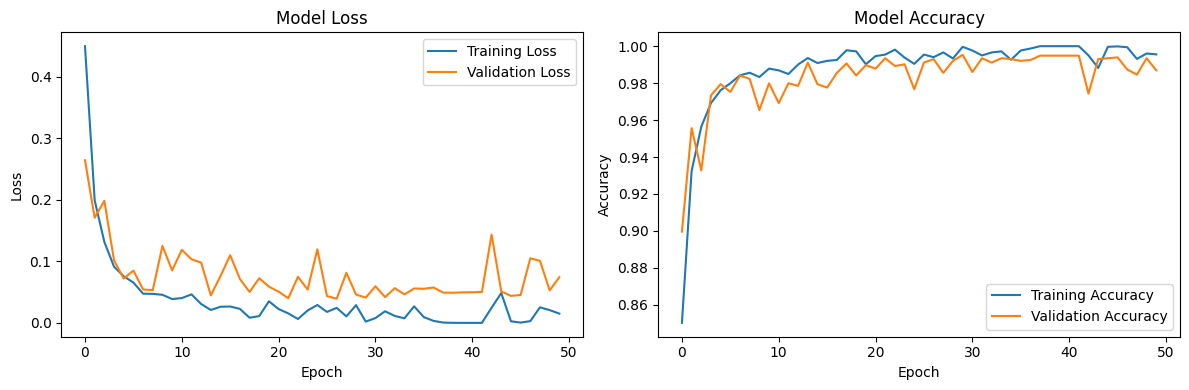

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Matriz de confusion

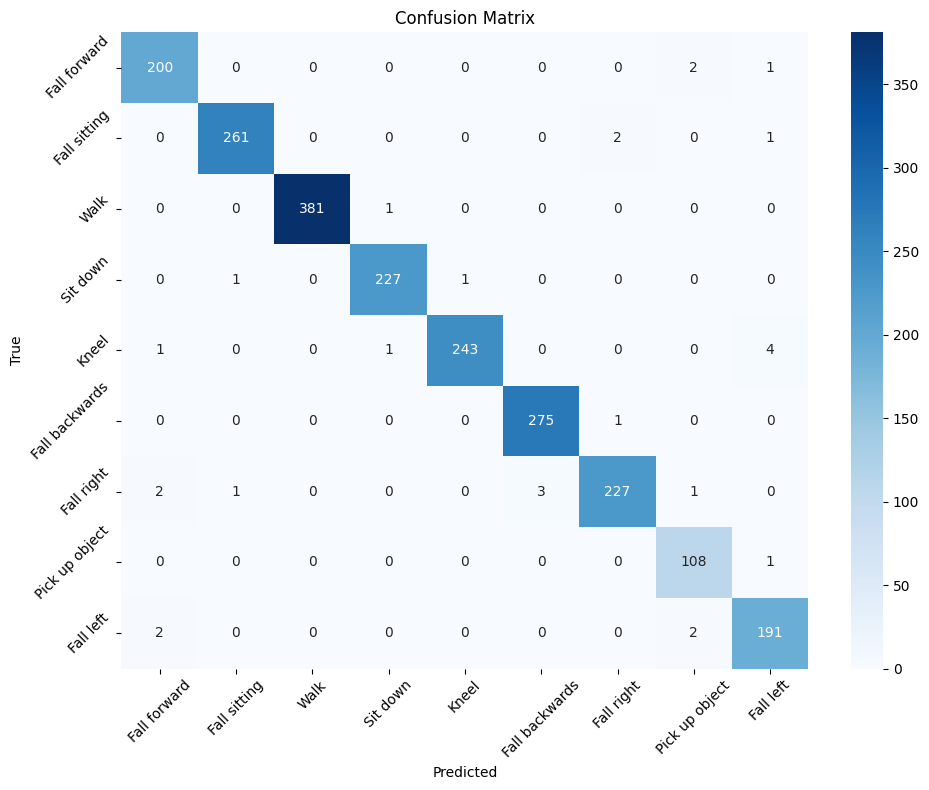

In [30]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_mapping,
            yticklabels=class_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()